# GN vs BN Karşılaştırması + Weight Standardization (WS)

Bu notebook’ta:
1) Baseline olarak **BatchNorm (BN)** kullanan bir CNN kuracağız.
2) Aynı mimariyi **GroupNorm (GN)** ile değiştireceğiz.
3) Ardından **Weight Standardization (WS)** ekleyerek eğitime ve stabiliteye etkisini gözlemleyeceğiz.

Amaç:
- Aynı mimari + aynı training ayarları ile BN vs GN farkını görmek
- GN üzerine WS ekleyince optimizasyon/stabilite/performans ne değişiyor görmek


-----
----
----
---

## (Code Hücresi) — BN 

### 1) Baseline Model: BatchNorm 

Aşağıdaki blok şu sırayla çalışır:
**Conv2d → BatchNorm2d → Aktivasyon**

BN batch istatistiği kullandığı için özellikle küçük batch'te dengesizleşebilir.
Bu baseline'ı kurmadan GN/WS karşılaştırması sağlıklı olmaz.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass

class ConvBNAct(nn.Module):
    def __init__(
        self,
        in_ch: int,
        out_ch: int,
        k: int = 3,
        s: int = 1,
        p: int | None = None,
        act: str = "silu",
        bias: bool = False,   # BN varken genelde bias=False
        eps: float = 1e-5,
        momentum: float = 0.1
    ):
        super().__init__()
        if p is None:
            p = k // 2

        self.conv = nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p, bias=bias)
        self.bn = nn.BatchNorm2d(out_ch, eps=eps, momentum=momentum, affine=True, track_running_stats=True)

        if act == "silu":
            self.act = nn.SiLU(inplace=True)
        elif act == "relu":
            self.act = nn.ReLU(inplace=True)
        elif act == "gelu":
            self.act = nn.GELU()
        else:
            raise ValueError(f"Unknown act: {act}")

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

### 2) Basit CNN (BN ile)

Bu model:
- Stem
- 3 stage (downsample)
- Global average pooling + Linear

GN/WS karşılaştırması yaparken:
- Mimari SABİT kalacak
- Sadece norm tipi (BN ↔ GN) ve opsiyonel WS değişecek


In [2]:
class SimpleBNNet(nn.Module):
    def __init__(self, num_classes: int = 10, width: int = 32):
        super().__init__()

        self.stem = nn.Sequential(
            ConvBNAct(3, width, k=3, s=2),      # /2
            ConvBNAct(width, width, k=3, s=1),
        )

        self.stage1 = nn.Sequential(
            ConvBNAct(width, width * 2, k=3, s=2),   # /4
            ConvBNAct(width * 2, width * 2, k=3, s=1),
        )

        self.stage2 = nn.Sequential(
            ConvBNAct(width * 2, width * 4, k=3, s=2),  # /8
            ConvBNAct(width * 4, width * 4, k=3, s=1),
        )

        self.stage3 = nn.Sequential(
            ConvBNAct(width * 4, width * 8, k=3, s=2),  # /16
            ConvBNAct(width * 8, width * 8, k=3, s=1),
        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(width * 8, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.pool(x).flatten(1)
        x = self.fc(x)
        return x

In [3]:
model = SimpleBNNet(num_classes=10, width=32)
x = torch.randn(4, 3, 224, 224)
y = model(x)
y.shape

torch.Size([4, 10])

### 3) Karşılaştırma İçin Minimal Ölçüm Planı (Şimdilik Skeleton)

BN vs GN vs (GN+WS) karşılaştırmasında aynı metrikleri toplayacağız:
- train loss
- val accuracy (veya task neyse)
- grad norm (stabilite göstergesi)
- loss spike sayısı (opsiyonel)

Şu hücre sadece altyapı; dataset'i senin seçimine göre bağlayacağız.


In [4]:
@dataclass
class TrainConfig:
    lr: float = 1e-3
    weight_decay: float = 1e-4
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


def train_one_step(model, optimizer, x, y):
    model.train()
    optimizer.zero_grad(set_to_none=True)
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()

    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5

    optimizer.step()
    return loss.item(), total_norm

### 4) BN + Weight Standardization (WS)

Bu kısımda BN baseline mimarisini bozmuyoruz.
Sadece Conv katmanlarını WS'li hale getiriyoruz:

**WSConv2d → BatchNorm2d → Aktivasyon**

Not:
- WS, Conv ağırlıklarını her out-channel için standardize eder.
- BN ile birlikte kullanınca bazı senaryolarda stabilite artabilir; 
  ama BN zaten normalizasyon yaptığı için kazanç GN+WS kadar "garanti" değildir.


In [5]:
class WSConv2d(nn.Conv2d):
    def __init__(self, *args, ws_eps: float = 1e-5, **kwargs):
        super().__init__(*args, **kwargs)
        self.ws_eps = ws_eps

    def forward(self, x):
        w = self.weight
        w_mean = w.mean(dim=(1, 2, 3), keepdim=True)
        w = w - w_mean
        w_var = w.pow(2).mean(dim=(1, 2, 3), keepdim=True)
        w = w / torch.sqrt(w_var + self.ws_eps)

        return F.conv2d(
            x, w, self.bias,
            self.stride, self.padding, self.dilation, self.groups
        )

In [6]:
class WSConvBNAct(nn.Module):
    """
    WSConv2d -> BatchNorm2d -> Activation
    """
    def __init__(
        self,
        in_ch: int,
        out_ch: int,
        k: int = 3,
        s: int = 1,
        p: int | None = None,
        act: str = "silu",
        bias: bool = False,     # BN varken genelde bias=False
        bn_eps: float = 1e-5,
        bn_momentum: float = 0.1,
        ws_eps: float = 1e-5,
    ):
        super().__init__()
        if p is None:
            p = k // 2

        self.conv = WSConv2d(in_ch, out_ch, k, stride=s, padding=p, bias=bias, ws_eps=ws_eps)
        self.bn = nn.BatchNorm2d(out_ch, eps=bn_eps, momentum=bn_momentum, affine=True, track_running_stats=True)

        if act == "silu":
            self.act = nn.SiLU(inplace=True)
        elif act == "relu":
            self.act = nn.ReLU(inplace=True)
        elif act == "gelu":
            self.act = nn.GELU()
        else:
            raise ValueError(f"Unknown act: {act}")

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

In [7]:
class SimpleBNWSNet(nn.Module):
    """
    Baseline CNN: (WSConv + BN) kullanır.
    Mimari, SimpleBNNet ile birebir aynı; tek fark Conv'ların WS'li olması.
    """
    def __init__(self, num_classes: int = 10, width: int = 32):
        super().__init__()

        self.stem = nn.Sequential(
            WSConvBNAct(3, width, k=3, s=2),      # /2
            WSConvBNAct(width, width, k=3, s=1),
        )

        self.stage1 = nn.Sequential(
            WSConvBNAct(width, width * 2, k=3, s=2),   # /4
            WSConvBNAct(width * 2, width * 2, k=3, s=1),
        )

        self.stage2 = nn.Sequential(
            WSConvBNAct(width * 2, width * 4, k=3, s=2),  # /8
            WSConvBNAct(width * 4, width * 4, k=3, s=1),
        )

        self.stage3 = nn.Sequential(
            WSConvBNAct(width * 4, width * 8, k=3, s=2),  # /16
            WSConvBNAct(width * 8, width * 8, k=3, s=1),
        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(width * 8, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.pool(x).flatten(1)
        x = self.fc(x)
        return x

In [8]:
model_bnws = SimpleBNWSNet(num_classes=10, width=32)
x = torch.randn(4, 3, 224, 224)
y = model_bnws(x)
y.shape

torch.Size([4, 10])

## Tam BN + WS Kodu

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WSConv2d(nn.Conv2d):
    def __init__(self, *args, ws_eps: float = 1e-5, **kwargs):
        super().__init__(*args, **kwargs)
        self.ws_eps = ws_eps

    def forward(self, x):
        w = self.weight
        w_mean = w.mean(dim=(1, 2, 3), keepdim=True)
        w = w - w_mean
        w_var = w.pow(2).mean(dim=(1, 2, 3), keepdim=True)
        w = w / torch.sqrt(w_var + self.ws_eps)

        return F.conv2d(
            x, w, self.bias,
            self.stride, self.padding, self.dilation, self.groups
        )

class WSConvBNAct(nn.Module):
    def __init__(
        self,
        in_ch: int,
        out_ch: int,
        k: int = 3,
        s: int = 1,
        p: int | None = None,
        act: str = "silu",
        bias: bool = False,    
        bn_eps: float = 1e-5,
        bn_momentum: float = 0.1,
        ws_eps: float = 1e-5,
    ):
        super().__init__()
        if p is None:
            p = k // 2

        self.conv = WSConv2d(in_ch, out_ch, k, stride=s, padding=p, bias=bias, ws_eps=ws_eps)
        self.bn = nn.BatchNorm2d(
            out_ch, eps=bn_eps, momentum=bn_momentum,
            affine=True, track_running_stats=True
        )

        if act == "silu":
            self.act = nn.SiLU(inplace=True)
        elif act == "relu":
            self.act = nn.ReLU(inplace=True)
        elif act == "gelu":
            self.act = nn.GELU()
        else:
            raise ValueError(f"Unknown act: {act}")

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class SimpleBNWSNet(nn.Module):
    def __init__(self, num_classes: int = 10, width: int = 32):
        super().__init__()

        self.stem = nn.Sequential(
            WSConvBNAct(3, width, k=3, s=2),      # /2
            WSConvBNAct(width, width, k=3, s=1),
        )

        self.stage1 = nn.Sequential(
            WSConvBNAct(width, width * 2, k=3, s=2),   # /4
            WSConvBNAct(width * 2, width * 2, k=3, s=1),
        )

        self.stage2 = nn.Sequential(
            WSConvBNAct(width * 2, width * 4, k=3, s=2),  # /8
            WSConvBNAct(width * 4, width * 4, k=3, s=1),
        )

        self.stage3 = nn.Sequential(
            WSConvBNAct(width * 4, width * 8, k=3, s=2),  # /16
            WSConvBNAct(width * 8, width * 8, k=3, s=1),
        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(width * 8, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.pool(x).flatten(1)
        x = self.fc(x)
        return x

if __name__ == "__main__":
    model = SimpleBNWSNet(num_classes=10, width=32)
    x = torch.randn(4, 3, 224, 224)
    y = model(x)
    print("Output shape:", y.shape)  # (4, 10)

Output shape: torch.Size([4, 10])


-------
-------
-------
---------

## 1) Aynı Mimariyi GroupNorm (GN) ile Kurmak

BN’den farkı:
- **BN** batch istatistiği (mean/var) kullanır → batch küçükse sapıtabilir
- **GN** batch’ten bağımsızdır → channel’ları gruplara ayırıp normalize eder

Bu bölümde:
- Önce **Conv → GN → Act** bloğunu yazıyoruz
- Sonra aynı CNN mimarisine entegre ediyoruz


### GN grup sayısı seçici

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def _pick_gn_groups(num_channels: int, max_groups: int = 32) -> int:
    g = min(max_groups, num_channels)
    while g > 1 and (num_channels % g) != 0:
        g -= 1
    return g

### GN Bloğu (WS yok)

In [11]:
class ConvGNAct(nn.Module):
    def __init__(
        self,
        in_ch: int,
        out_ch: int,
        k: int = 3,
        s: int = 1,
        p: int | None = None,
        act: str = "silu",
        bias: bool = False,
        gn_groups: int | None = None,
        gn_eps: float = 1e-5,
        max_gn_groups: int = 32,
    ):
        super().__init__()
        if p is None:
            p = k // 2

        self.conv = nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p, bias=bias)

        if gn_groups is None:
            gn_groups = _pick_gn_groups(out_ch, max_groups=max_gn_groups)

        self.gn = nn.GroupNorm(num_groups=gn_groups, num_channels=out_ch, eps=gn_eps, affine=True)

        if act == "silu":
            self.act = nn.SiLU(inplace=True)
        elif act == "relu":
            self.act = nn.ReLU(inplace=True)
        elif act == "gelu":
            self.act = nn.GELU()
        else:
            raise ValueError(f"Unknown act: {act}")

    def forward(self, x):
        return self.act(self.gn(self.conv(x)))

## 5) GN Baseline Model (WS yok)

Bu model, BN baseline ile **birebir aynı mimari**:
- Stem
- 3 stage downsample
- Global average pooling + Linear

Tek fark: **BatchNorm yerine GroupNorm** kullanıyoruz.


In [12]:
class SimpleGNNet(nn.Module):
    def __init__(self, num_classes: int = 10, width: int = 32, max_gn_groups: int = 32):
        super().__init__()

        def B(in_ch, out_ch, k=3, s=1):
            return ConvGNAct(in_ch, out_ch, k=k, s=s, max_gn_groups=max_gn_groups)

        self.stem = nn.Sequential(
            B(3, width, k=3, s=2),      # /2
            B(width, width, k=3, s=1),
        )

        self.stage1 = nn.Sequential(
            B(width, width * 2, k=3, s=2),   # /4
            B(width * 2, width * 2, k=3, s=1),
        )

        self.stage2 = nn.Sequential(
            B(width * 2, width * 4, k=3, s=2),  # /8
            B(width * 4, width * 4, k=3, s=1),
        )

        self.stage3 = nn.Sequential(
            B(width * 4, width * 8, k=3, s=2),  # /16
            B(width * 8, width * 8, k=3, s=1),
        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(width * 8, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.pool(x).flatten(1)
        x = self.fc(x)
        return x

In [13]:
model_gn = SimpleGNNet(num_classes=10, width=32, max_gn_groups=32)
x = torch.randn(4, 3, 224, 224)
y = model_gn(x)
y.shape

torch.Size([4, 10])

## 6) GN + Weight Standardization (WS)

Şimdi GN bloğundaki Conv'u WS'li hale getiriyoruz:

**WSConv2d → GroupNorm → Aktivasyon**

WS burada daha anlamlı:
- BN zaten normalizasyon yaptığı için WS+BN kazancı bazen sınırlı kalır
- GN batch'ten bağımsız olduğu için optimizasyonu “pürüzsüzleştirme” WS ile daha net görülebilir


In [14]:
class WSConv2d(nn.Conv2d):
    def __init__(self, *args, ws_eps: float = 1e-5, **kwargs):
        super().__init__(*args, **kwargs)
        self.ws_eps = ws_eps

    def forward(self, x):
        w = self.weight
        w_mean = w.mean(dim=(1, 2, 3), keepdim=True)
        w = w - w_mean
        w_var = w.pow(2).mean(dim=(1, 2, 3), keepdim=True)
        w = w / torch.sqrt(w_var + self.ws_eps)

        return F.conv2d(
            x, w, self.bias,
            self.stride, self.padding, self.dilation, self.groups
        )

In [15]:
class WSConvGNAct(nn.Module):
    def __init__(
        self,
        in_ch: int,
        out_ch: int,
        k: int = 3,
        s: int = 1,
        p: int | None = None,
        act: str = "silu",
        bias: bool = False,
        gn_groups: int | None = None,
        gn_eps: float = 1e-5,
        max_gn_groups: int = 32,
        ws_eps: float = 1e-5,
    ):
        super().__init__()
        if p is None:
            p = k // 2

        self.conv = WSConv2d(in_ch, out_ch, k, stride=s, padding=p, bias=bias, ws_eps=ws_eps)

        if gn_groups is None:
            gn_groups = _pick_gn_groups(out_ch, max_groups=max_gn_groups)

        self.gn = nn.GroupNorm(num_groups=gn_groups, num_channels=out_ch, eps=gn_eps, affine=True)

        if act == "silu":
            self.act = nn.SiLU(inplace=True)
        elif act == "relu":
            self.act = nn.ReLU(inplace=True)
        elif act == "gelu":
            self.act = nn.GELU()
        else:
            raise ValueError(f"Unknown act: {act}")

    def forward(self, x):
        return self.act(self.gn(self.conv(x)))

## 7) GN+WS Model (Final)

BN+WS model ile mimari tamamen aynı.
Sadece norm GN, conv WS'li.
Böylece kıyas:
- BN
- BN+WS
- GN
- GN+WS
“aynı mimari” garantisiyle yapılır.


In [16]:
class SimpleGNWSNet(nn.Module):
    def __init__(self, num_classes: int = 10, width: int = 32, max_gn_groups: int = 32):
        super().__init__()

        def B(in_ch, out_ch, k=3, s=1):
            return WSConvGNAct(in_ch, out_ch, k=k, s=s, max_gn_groups=max_gn_groups)

        self.stem = nn.Sequential(
            B(3, width, k=3, s=2),      # /2
            B(width, width, k=3, s=1),
        )

        self.stage1 = nn.Sequential(
            B(width, width * 2, k=3, s=2),   # /4
            B(width * 2, width * 2, k=3, s=1),
        )

        self.stage2 = nn.Sequential(
            B(width * 2, width * 4, k=3, s=2),  # /8
            B(width * 4, width * 4, k=3, s=1),
        )

        self.stage3 = nn.Sequential(
            B(width * 4, width * 8, k=3, s=2),  # /16
            B(width * 8, width * 8, k=3, s=1),
        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(width * 8, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.pool(x).flatten(1)
        x = self.fc(x)
        return x

In [17]:
model_gnws = SimpleGNWSNet(num_classes=10, width=32, max_gn_groups=32)
x = torch.randn(4, 3, 224, 224)
y = model_gnws(x)
y.shape

torch.Size([4, 10])

--------
-------
-----
------

## 8) Model Factory + Tek Training Loop ile 4 Modeli Karşılaştırma

Kıyaslanacak modeller (aynı mimari, sadece norm/WS değişiyor):
1. **BN**
2. **BN + WS**
3. **GN**
4. **GN + WS**

Her epoch sonunda:
- train loss
- val accuracy
- grad norm (stabilite göstergesi)

Not: CIFAR-10 kullanıyoruz (hızlı ablation için ideal).


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
])

train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tf)
test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tf)

batch_size = 128  
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

device: cuda
Files already downloaded and verified
Files already downloaded and verified


## 9) Modellerin Tamamı (BN, BN+WS, GN, GN+WS)

Aşağıdaki hücre:
- GN grup seçici
- WSConv2d
- 4 farklı blok
- 4 farklı model sınıfı içerir


In [19]:
def _pick_gn_groups(num_channels: int, max_groups: int = 32) -> int:
    g = min(max_groups, num_channels)
    while g > 1 and (num_channels % g) != 0:
        g -= 1
    return g


class WSConv2d(nn.Conv2d):
    def __init__(self, *args, ws_eps: float = 1e-5, **kwargs):
        super().__init__(*args, **kwargs)
        self.ws_eps = ws_eps

    def forward(self, x):
        w = self.weight
        w_mean = w.mean(dim=(1, 2, 3), keepdim=True)
        w = w - w_mean
        w_var = w.pow(2).mean(dim=(1, 2, 3), keepdim=True)
        w = w / torch.sqrt(w_var + self.ws_eps)
        return F.conv2d(x, w, self.bias, self.stride, self.padding, self.dilation, self.groups)

class ConvBNAct(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=None, act="silu", bias=False, bn_eps=1e-5, bn_momentum=0.1):
        super().__init__()
        if p is None:
            p = k // 2
        self.conv = nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p, bias=bias)
        self.bn = nn.BatchNorm2d(out_ch, eps=bn_eps, momentum=bn_momentum, affine=True, track_running_stats=True)
        self.act = nn.SiLU(inplace=True) if act == "silu" else nn.ReLU(inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))


class WSConvBNAct(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=None, act="silu", bias=False, bn_eps=1e-5, bn_momentum=0.1, ws_eps=1e-5):
        super().__init__()
        if p is None:
            p = k // 2
        self.conv = WSConv2d(in_ch, out_ch, k, stride=s, padding=p, bias=bias, ws_eps=ws_eps)
        self.bn = nn.BatchNorm2d(out_ch, eps=bn_eps, momentum=bn_momentum, affine=True, track_running_stats=True)
        self.act = nn.SiLU(inplace=True) if act == "silu" else nn.ReLU(inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))


class ConvGNAct(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=None, act="silu", bias=False, gn_eps=1e-5, max_gn_groups=32):
        super().__init__()
        if p is None:
            p = k // 2
        self.conv = nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p, bias=bias)
        g = _pick_gn_groups(out_ch, max_groups=max_gn_groups)
        self.gn = nn.GroupNorm(g, out_ch, eps=gn_eps, affine=True)
        self.act = nn.SiLU(inplace=True) if act == "silu" else nn.ReLU(inplace=True)

    def forward(self, x):
        return self.act(self.gn(self.conv(x)))


class WSConvGNAct(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=None, act="silu", bias=False, gn_eps=1e-5, max_gn_groups=32, ws_eps=1e-5):
        super().__init__()
        if p is None:
            p = k // 2
        self.conv = WSConv2d(in_ch, out_ch, k, stride=s, padding=p, bias=bias, ws_eps=ws_eps)
        g = _pick_gn_groups(out_ch, max_groups=max_gn_groups)
        self.gn = nn.GroupNorm(g, out_ch, eps=gn_eps, affine=True)
        self.act = nn.SiLU(inplace=True) if act == "silu" else nn.ReLU(inplace=True)

    def forward(self, x):
        return self.act(self.gn(self.conv(x)))

class SimpleNet(nn.Module):
    def __init__(self, block_cls, num_classes=10, width=64, **block_kwargs):
        super().__init__()

        def B(in_ch, out_ch, k=3, s=1):
            return block_cls(in_ch, out_ch, k=k, s=s, **block_kwargs)

        self.stem = nn.Sequential(
            B(3, width, k=3, s=1),
            B(width, width, k=3, s=1),
        )
        self.stage1 = nn.Sequential(
            B(width, width * 2, k=3, s=2),      # 32 -> 16
            B(width * 2, width * 2, k=3, s=1),
        )
        self.stage2 = nn.Sequential(
            B(width * 2, width * 4, k=3, s=2),  # 16 -> 8
            B(width * 4, width * 4, k=3, s=1),
        )
        self.stage3 = nn.Sequential(
            B(width * 4, width * 8, k=3, s=2),  # 8 -> 4
            B(width * 8, width * 8, k=3, s=1),
        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(width * 8, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)

def make_model(name: str, num_classes=10, width=64, max_gn_groups=32):
    name = name.lower()
    if name == "bn":
        return SimpleNet(ConvBNAct, num_classes=num_classes, width=width)
    if name == "bnws":
        return SimpleNet(WSConvBNAct, num_classes=num_classes, width=width)
    if name == "gn":
        return SimpleNet(ConvGNAct, num_classes=num_classes, width=width, max_gn_groups=max_gn_groups)
    if name == "gnws":
        return SimpleNet(WSConvGNAct, num_classes=num_classes, width=width, max_gn_groups=max_gn_groups)
    raise ValueError("Unknown model name. Use: bn, bnws, gn, gnws")

## 10) Tek Training Loop + Eval + GradNorm Log

Aynı optimizer, aynı LR, aynı epoch sayısı.
Her model için aynı loop çalışacak.


In [20]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = F.cross_entropy(logits, y)

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


def grad_norm_l2(model):
    total_sq = 0.0
    for p in model.parameters():
        if p.grad is None:
            continue
        n = p.grad.data.norm(2).item()
        total_sq += n * n
    return total_sq ** 0.5


def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    total = 0
    gn_accum = 0.0
    steps = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()

        gn_accum += grad_norm_l2(model)
        steps += 1

        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total += x.size(0)

    return total_loss / total, (gn_accum / max(steps, 1))

## 11) Runner: 4 Modelin Hepsini Aynı Koşullarda Çalıştır

Buradan sonra tek oynayacağın şeyler:
- `epochs`
- `batch_size` (özellikle 8/16 yapıp BN vs GN farkını patlat)
- `width` (kapasite)

Çıktı: her epoch için loss/acc/grad_norm


In [ ]:
def run_experiment(model_name: str, epochs: int = 5, lr: float = 1e-3, wd: float = 1e-4, width: int = 32):
    model = make_model(model_name, num_classes=10, width=width, max_gn_groups=32).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    history = []
    for epoch in range(1, epochs + 1):
        tr_loss, tr_gn = train_one_epoch(model, train_loader, optimizer)
        te_loss, te_acc = evaluate(model, test_loader)

        row = {
            "model": model_name,
            "epoch": epoch,
            "train_loss": tr_loss,
            "test_loss": te_loss,
            "test_acc": te_acc,
            "grad_norm": tr_gn,
        }
        history.append(row)
        print(f"[{model_name}] epoch {epoch:02d} | train_loss={tr_loss:.4f} | test_acc={te_acc*100:.2f}% | grad_norm={tr_gn:.3f}")

    return history


all_hist = []
for name in ["bn", "bnws", "gn", "gnws"]:
    all_hist += run_experiment(name, epochs=5, lr=1e-3, wd=1e-4, width=64)

[bn] epoch 01 | train_loss=1.4961 | test_acc=53.97% | grad_norm=2.027
[bn] epoch 02 | train_loss=1.0271 | test_acc=59.49% | grad_norm=2.428
[bn] epoch 03 | train_loss=0.8174 | test_acc=73.73% | grad_norm=2.116
[bn] epoch 04 | train_loss=0.6894 | test_acc=72.57% | grad_norm=1.821
[bn] epoch 05 | train_loss=0.5988 | test_acc=78.32% | grad_norm=1.639
[bnws] epoch 01 | train_loss=1.4340 | test_acc=59.59% | grad_norm=1.799
[bnws] epoch 02 | train_loss=0.9881 | test_acc=67.53% | grad_norm=1.708
[bnws] epoch 03 | train_loss=0.7811 | test_acc=76.74% | grad_norm=1.522
[bnws] epoch 04 | train_loss=0.6586 | test_acc=78.36% | grad_norm=1.377
[bnws] epoch 05 | train_loss=0.5821 | test_acc=79.84% | grad_norm=1.311
[gn] epoch 01 | train_loss=1.9020 | test_acc=42.19% | grad_norm=2.165
[gn] epoch 02 | train_loss=1.4981 | test_acc=51.24% | grad_norm=2.759
[gn] epoch 03 | train_loss=1.2409 | test_acc=60.59% | grad_norm=3.172
[gn] epoch 04 | train_loss=1.0335 | test_acc=65.21% | grad_norm=3.371
[gn] epoch

## 12) Sonuçları Tabloya Dökelim


In [23]:
import pandas as pd

df = pd.DataFrame(all_hist)
df

,model,epoch,train_loss,test_loss,test_acc,grad_norm
0,bn,1,1.496135,1.274882,0.5397,2.027180
1,bn,2,1.027089,1.143453,0.5949,2.427572
2,bn,3,0.817405,0.763850,0.7373,2.116459
3,bn,4,0.689447,0.798502,0.7257,1.821335
4,bn,5,0.598830,0.626172,0.7832,1.639231
5,bnws,1,1.434035,1.132802,0.5959,1.798678
6,bnws,2,0.988053,0.936379,0.6753,1.707748
7,bnws,3,0.781056,0.687943,0.7674,1.522211
8,bnws,4,0.658640,0.645553,0.7836,1.376944
9,bnws,5,0.582144,0.601166,0.7984,1.310731


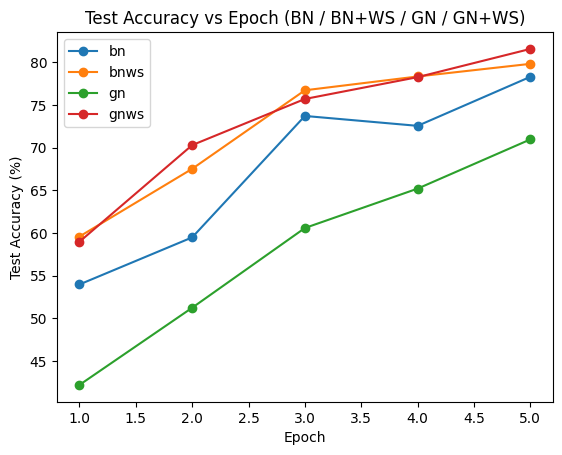

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure()
for m, g in df.groupby("model"):
    plt.plot(g["epoch"], g["test_acc"], marker="o", label=m)

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy vs Epoch (BN / BN+WS / GN / GN+WS)")
plt.legend()
plt.show()


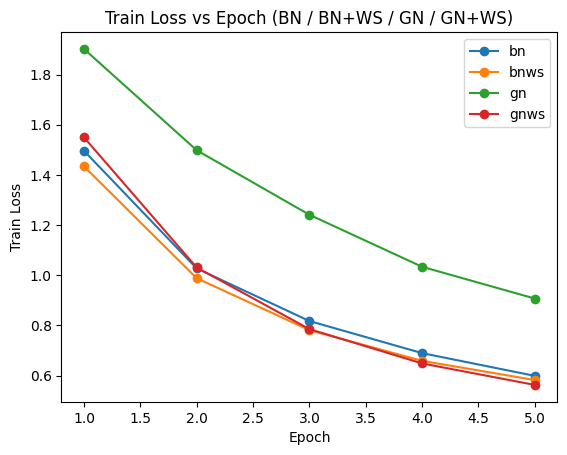

In [26]:
plt.figure()
for m, g in df.groupby("model"):
    plt.plot(g["epoch"], g["train_loss"], marker="o", label=m)

plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Train Loss vs Epoch (BN / BN+WS / GN / GN+WS)")
plt.legend()
plt.show()


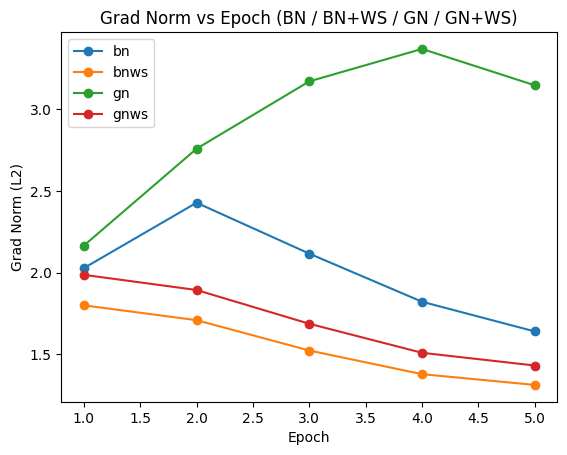

In [ ]:
plt.figure()
for m, g in df.groupby("model"):
    plt.plot(g["epoch"], g["grad_norm"], marker="o", label=m)

plt.xlabel("Epoch")
plt.ylabel("Grad Norm (L2)")
plt.title("Grad Norm vs Epoch (BN / BN+WS / GN / GN+WS)")
plt.legend()
plt.show()

# Grad Norm nedir? 🔍

* Grad norm, modeldeki tüm parametrelerin gradyanlarının büyüklüğünü tek bir sayıya indirger.
* Genelde L2 norm kullanılır.

## Grad Norm bize neyi söyler?
### 1) Eğitim stabilitesi

* Çok büyük grad norm →
⚠️ gradient explosion, loss spike, optimizer zorlanıyor

* Çok küçük grad norm →
⚠️ learning durmuş olabilir (vanishing gradient)

### 2) Optimizer’ın ne kadar “zorlandığı”

* Düzgün ve yavaş azalan grad norm → sağlıklı öğrenme

* Epoch’lar arasında zıplayan grad norm → instabil training

## Bizim sonuçlarımıza bakarsak 👇
### GN (WS yok)

**grad_norm: 2.16 → 2.75 → 3.17 → 3.37 → 3.15**


* Sürekli yukarı tırmanıyor

* GN batch’ten bağımsız ama ağırlık dağılımı kontrolsüz

* Optimizer daha sert güncelleme yapıyor

### GN + WS
**grad_norm: 1.98 → 1.89 → 1.68 → 1.50 → 1.43**

* Düzenli düşüş

* WS, conv ağırlıklarını normalize ettiği için
→ gradyanlar daha dengeli geliyor

### BN vs BN+WS

* BN zaten normalize ettiği için grad_norm farkı daha az dramatik

* Ama BN+WS daha pürüzsüz (daha düşük ve stabil)

## Özet  🎯

**Grad norm = eğitim sırasında optimizer’ın modele ne kadar “sert vurduğunu” gösteren stabilite göstergesi.**

Bizim deneyde net sonuç:

* GN tek başına → çalışıyor ama sert

* GN + WS → daha stabil + daha iyi accuracy

Bu yüzden “GN + WS default” demek tam isabet.